In [3]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import scipy.stats as st
import matplotlib.pyplot as plt


In [4]:
# Alphas and betas are hard coded into the functions 

def rfp_roots(atc,iptg,param):
    '''
    This functin accepts the inducer levels (single set) and parameter values for the model and 
    returns the rfp values of the fixed points in phase space for the given inputs/parameters. 
    Gfp levels can be computed from the rfp values found here.
    
    Note this function should return either one or three rfp values. If it returns three values, they
    should be in increasing order with the middle value corresponding to an unstable fixed point and
    the lower and higher values corresponds to stable fixed points. This is due to the type of 
    bifurcation the model undergoes. If one rfp value is returned it should always be stable. Stable
    means it is an rfp value the system can settle down to after being left to equilibrate over a
    long time (i.e. 6-8 hours as in experiments)
    Mathematically this is a root finding problem. The function we need the roots of is an algebraic
    combination of the model's steady state equations for the rfp and gfp levels. However it is more
    complex then just running default root finding because for any given input/parameter set,
    we don't know if there is 1 or 3 roots and the search interval can change. The approach used here
    is to use a bisecting grid search to find intervals in which the roots can be found and then to
    run a normal root finding algorihtm (a variant of bisection search) on each interval.
    Parameters here are expected in their natural scaling (i.e. no log transform)
    '''
    #NOTE:
    #laci=rfp=high atc
    #tetr=gfp=high iptg
    #param = alpha_1, beta_1, K_1, kappa_1, alpha_2, beta_2, K_2, kappa_2

    # model consists of two equations rfp=g1(gfp,inputs) and gfp=g2(rfp,inputs)
    # this function implements 0=g1(g2(rfp,inputs),inputs)-rfp
    # the lower and upper roots of this function for rfp correspond to model branches
    # to get gfp we take the rfp root and sub it in g2, i.e. gfp=g2(rfp_root,inputs)
    rfp_root_func = lambda rfp: 13.609 + 3529.923/(1+((
        (60.882 + 1053.916/(1+((rfp/param[2])*(1/(1+(iptg/param[3])**2.0)))**2.0))
        /param[0])*(1/(1+(atc/param[1])**2.0)))**2.0)-rfp
    


    #extract the min and max possible rfp values from the model parameters, roots will occur in this
    #intervale
    min_rfp = 13.609
    max_rfp = 13.609 + 3529.923

    #set the search tolerance over the rfp range, below this tolerance 3 nearby roots and a single
    #root will look the same to the algorithm
    tol = (max_rfp - min_rfp)*.01

    #create a grid of rfp points spanning the feasible range
    grid = np.array([min_rfp, max_rfp])
    #evaluet the signe of g1(g2(rfp,inputs),inputs)-rfp, on the end points of the interval
    #these two points should have opposite signs as they are on opposite sides of a root
    sign = np.array([np.sign(rfp_root_func(min_rfp)),np.sign(rfp_root_func(max_rfp))])
    #initialize the sign change count, telling us the current known number of sign changes occuring 
    # over the grid for the function g1(g2(rfp,inputs),inputs)-rfp
    sgn_change_count=1
    sign_change_bool = []
    #set the current grid space to the spacing of the endpoints in grid array
    grid_spacing = max_rfp - min_rfp
    # loop until we either find that these inputs have 3 roots or we have subdivide grid into 
    # spacing smaller than the search tolerence
    while sgn_change_count==1 and grid_spacing>tol:
        #compute the rfp values that bisect all the current grid points
        bisect_points = (grid[:-1]+grid[1:])/2
        #evaluate the sign of the current grid points passed to root funciton: g1(g2(rfp,inputs),inputs)-rfp
        bisect_signs = np.sign(rfp_root_func(bisect_points))

        #create a new grid 
        new_grid = np.empty((grid.size + bisect_points.size,), dtype=grid.dtype)
        #add the old grid points
        new_grid[0::2] = grid
        #add the bisection points, basically doubles size/fineness of the grid
        new_grid[1::2] = bisect_points

        #create a new sign array
        new_sign = np.empty((sign.size + bisect_signs.size,), dtype=sign.dtype)
        #add old sign values for root function on old grid points
        new_sign[0::2] = sign
        #dd new sign values for root function on new bisected grid points
        new_sign[1::2] = bisect_signs

        #overight the original grid and sign arrays for next loop
        grid = new_grid
        sign = new_sign

        #create a boolean array indicating if a sign change in the root function occurs on each 
        #interval of the grid, if so there is either 1 or 3 roots in that grid interval
        sign_change_bool= abs(np.diff(sign)/2)
        #count the number of signs changes, and thus roots that we know about
        sgn_change_count = sum(sign_change_bool)
        #refine the grid spacing
        grid_spacing = grid[1] - grid[0]

    #after loop end we have either found 3 roots or know there is 1 root up to the given tolerence
    #we know take the grid and pull out the rfp grid intervals bracketing the known roots
    search_intervals = [(grid[i], grid[i+1]) 
                            for i in range(len(sign_change_bool))
                                if sign_change_bool[i]]
    
    #create an empy list to store the rfp roots we will return
    fixed_points=[]
    #loop over each rfp grid interval where there was a sign change in the root function
    for interval in search_intervals:
        #for each interval run the root finding function to find the rfp root value accurately 
        fixed_point = opt.root_scalar(rfp_root_func,method='brentq',bracket=interval).root
        # add the root to the list
        fixed_points.append(fixed_point)

    #return the list of roots i.e. fixed points
    return fixed_points


def stable_points(atc,iptg,par):
    '''
    This function accepts the inducer levels and the parameter values and returns a list of
    rfp and gfp points corresponding to the models stable fixed points at these inputs.
    This function calls the rfp_roots function. This function only returns stable fixed points and
    returns both rfp and gfp corrdinates in a list of tuples.
    Parameters here are expected to be log transformed (i.e. we exponentiate the values passed
     to get the numerical values from the paper/writeup). This is because this function will be
     called by the logelikelihood/squared errror function for fitting and fitting should happen
     on the log transformed valued of the natural parameters so that the natural parameter value
     is always positive.
    '''
    #exponeniate the parameters to get them on the natural scale
    param = np.exp(par)

    #implement the gfp steady-state function, mapping rfp, inputs and parameters to gfp
    gfp_func = lambda rfp,iptg: 60.882 + 1053.916/(1+((rfp/param[2])*(1/(1+(iptg/param[3])**2.0)))**2.0)


    #call the rfp_roots function to get the stable rfp values
    rfp = rfp_roots(atc,iptg,param)

    #check if 1 or 3 rfp roots returned
    if len(rfp)==1:
        #compute gfp level for a single root, tuple with rfp and return
        gfp = gfp_func(rfp[0],iptg)
        return [np.array([rfp[0],gfp])]
    elif len(rfp)==3:
        #compute gfp level for smallest and largest roots, tuple with rfps and return
        gfp_low = gfp_func(rfp[0],iptg)
        gfp_high = gfp_func(rfp[2],iptg)
        return [np.array([rfp[0],gfp_low]),np.array([rfp[2],gfp_high])]
    else:
        #should never get here
        return 0


def generate_data(u_list, endpoints, param, batch=True):
    
    '''
    This function generates simulated data for the model. This can be used to evaluate fitting and
    check how we expect the fitting algorithm to perform.
    u_list is a list of tuples, one for each input level used in the experiment. Each tuple
    has three entries:
    u[0] is the % of master atc media in the 
    u[1] is a boolean, true if ATC overnight was used, false if IPTG was used
    u[2] is the number of cells measured in the given input condition
    And example u_list for 3 input levels of 0%, 50% and 100% ATC, with both ATC and IPTG overnights
    in each condition and 200 cells segmented from each would be:
    [(0.0,True,200),(0.5,True,200),(1.0,True,200),(0.0,False,200),(0.5,False,200),(1.0,False,200)]
    Endpoints is list with two tuples in it, the first tuple is the point in ATC x IPTG space with
    the greater ATC value (i.e. high atc or pure atc master media mix), the second is the point 
    in input inducer space with the low/zero ATC level.
    It is assumed all experiments measure the system along some linear combination of the ATC and IPTG
    mixtures specified by the end points. 
    This function returns a dataframe with the simulated data in it. The columns in the dataframe are:
    perc,atc,iptg,rfp,gfp,branch,num
    perc - is the ATC master percentage from 0-1
    atc - is the actual atc concentration in ng/ml
    iptg - is the actual iptg concentration in mM
    rfp - is the observed rfp value (mean if batch=True, single cell if batch=False)
    gfp - is the observed gfp value
    branch - is a boolean indicating if ATC overnight (True) or IPTG overnight (False) was used
    num - (optional, only if batch=True) is the number of segmented cells observed in that condition
                                        used to compute rfp and gfp mean observations
    The returned data by default is in batch mode (batch=True) in which case single cell observations
    of the same input condition are mered into a single row, the mean rfp and gfp values are returned
    and the numberd of cell involved in the mean is given in the num column. If batch=False is used
    the function returns a dataframe where each row corresponds to a single cell. This can be useful
    for plotting or more complex likelihood functions, if we ever get to them.
    '''
    #NOTE:
    #branch label is true if prepped in ATC overnight, false if IPTG

    #create lists for input percentage atc, input values (atc, iptg), observations (rfp,gfp),
    #branch_lables (True/False Atc overnight), and number of cells
    #values are accumulated in these lists and merged into a dataframe at the end
    input_perc = []
    input_values = []
    observations = []
    branch_labels = []
    num_cells = []
    #loop over the input list
    for u in u_list:
        #compute the input values (ng/ml, mM) from the atc perc. and the endpoints
        inputs = u[0]*endpoints[0] + (1-u[0])*endpoints[1]
        #compute the stable rfp,gfp pairs for the given inputs (and parameters)
        points = stable_points(inputs[0],inputs[1],param)

        #check if 1 or 2 stable points
        if len(points)==1:
            #if 1 point,  generate the approriate number of rfp,gfp observations
            obs = np.random.multivariate_normal(points[0],np.diagflat((0.1*points[0])**2),u[2])
        elif len(points)==2:
            #if 2 points, check which overnight was used
            if not u[1]:
                #generated observations arround lower rfp branch if IPTG overnight was used
                obs = np.random.multivariate_normal(points[0],np.diagflat((0.1*points[0])**2),u[2])
            else:
                #generated observations arround upper rfp branch if ATC overnight was used
                obs = np.random.multivariate_normal(points[1],np.diagflat((0.1*points[1])**2),u[2])

        #check if data is batched or single cell
        if batch:
            #if batched, set reps to 1 (numbers of rows for each input list condition)
            reps = 1
            #add the number of cells to be observed in the given condition to the num_cells list
            num_cells.append(u[2])
            #compute the mean of the rfp and gfp values observed for each cell (we could be more efficient here)
            data = np.mean(obs,axis=0)
        else:
            #if single cell data is desired, set reps to number of cells (one row per cell)
            reps = u[2]
            #add all of the single cell observations to the data variable
            data = obs

        #append the inputs/observations for the current input_list condition to the storage lists
        input_perc.append(np.repeat(u[0],reps))
        input_values.append(np.tile(inputs,(reps,1)))
        observations.append(data)
        branch_labels.append(np.full(reps,u[1]))

    #merge the storage lists into numpy arrays
    input_perc = np.concatenate(input_perc)
    input_values = np.vstack(input_values)
    observations = np.vstack(observations)
    branch_labels = np.concatenate(branch_labels)

    #create the pandas dataframe for the data
    dataset = df = pd.DataFrame(data={'perc':input_perc,
                                      'atc':input_values[:,0],
                                      'iptg':input_values[:,1],
                                      'rfp':observations[:,0],
                                      'gfp':observations[:,1],
                                      'branch':branch_labels})

    #if data is batched, add the number of cells column to the dataframe
    if batch:
        num_cells = np.array(num_cells)
        dataset['num'] = num_cells

    return dataset


def loglike(param, dataset):
    '''
    This function computes the loglikelihood for the model with the given parameter values on the
    passed dataset (formated as a pandas array, like in the data generating function)
    This function assumes the dataset is in batched form, this makes things more efficient
    This function can be used, in conjunction with an numpy optimization function, to fit the model
    '''
    
    #create a accumulator variable for the loglikelihood and set the value to zero
    ll=0

    #loop over rows in the dataframe
    for i,row in dataset.iterrows():

        #for the current row's input conditions, compute the expected stable points (rfp,gfp) with
        #passed parameters
        points = stable_points(row['atc'],row['iptg'],param)

        #check if current input points, with passed parameters has 1 or 2 stable points
        if len(points)==1:
            #if a single stable points add the log pdf of the data to the loglikelihood accumulation
            #function
            ll = ll + np.log(st.multivariate_normal.pdf([row['rfp'],row['gfp']], points[0], np.diagflat((0.1*points[0])**2))/row['num'])
        else:
            #if there are 2 stable points, check overnight condition
            if not row['branch']:
                #if iptg overnight, compute log-pdf value of data around lower rfp stable point
                ll = ll + np.log(st.multivariate_normal.pdf([row['rfp'],row['gfp']], points[0], np.diagflat((0.1*points[0])**2))/row['num'])
            else:
                #if atc overnight, compute log-pdf value of data around upper rfp stable point
                ll = ll + np.log(st.multivariate_normal.pdf([row['rfp'],row['gfp']], points[1], np.diagflat((0.1*points[1])**2))/row['num'])

    #return the accumulated loglikelihood, this value needs to be maximized
    return ll

def squared_error(param, dataset):
    '''
    This function computes the sum of squared error for the model with the given parameter values on the
    passed dataset (formated as a pandas array, like in the data generating function)
    This function assumes the dataset is in batched form, this makes things more efficient
    This function can be used, in conjunction with an numpy optimization function, to fit the model
    '''
    #create an accumulator variable for the sum of squared error, and set it to zero
    sse=0

    #loop over the rows of the dataset
    for i,row in dataset.iterrows():
        
        #for the current row's input conditions, compute the expected stable points (rfp,gfp) with
        #passed parameters
        points = stable_points(row['atc'],row['iptg'],param)

        #check if current input points, with passed parameters has 1 or 2 stable points
        if len(points)==1:
            #if a single stable points add sum of squared error between the observation and the stable
            #point
            sse = sse + ((np.log(row['rfp']/row['gfp']))-(np.log(points[0][0]/points[0][1])))**2
        else:
            #if there are 2 stable points, check overnight condition
            if not row['branch']:
                #if iptg overnight, compute log-pdf value of data around lower rfp stable point
                sse = sse + ((np.log(row['rfp']/row['gfp']))-(np.log(points[0][0]/points[0][1])))**2
            else:
                #if atc overnight, compute log-pdf value of data around upper rfp stable point
                sse = sse + ((np.log(row['rfp']/row['gfp']))-(np.log(points[0][0]/points[0][1])))**2

            #Code above assumes all observations have the same variance/covariance, commented below is
            #part of a weighted least squares computation that accounts for changeing variance
            #haven't tested much
            # if not row['branch']:
            #     sse = sse + row['num']*(row['rfp'] - points[0][0])**2/points[0][0]**2 \
            #                 + row['num']*(row['gfp'] - points[0][1])**2/points[0][1]**2
            # else:
            #     sse = sse + row['num']*(row['rfp'] - points[1][0])**2/points[1][0]**2 \
            #                  + row['num']*(row['gfp'] - points[1][1])**2/points[1][1]**2

    #return accumulated sum of squared error, this value should be minimized
    return sse

1


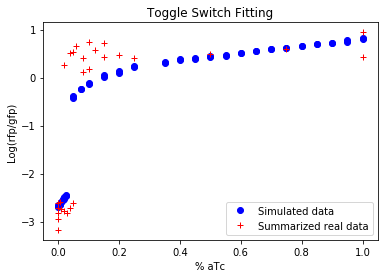

In [23]:
#Inital Parameters
alpha_1 = 13.609  # Hard Coded
alpha_2 = 60.882  # Hard Coded
beta_1 = 3529.923  # Hard Coded 
beta_2 = 1053.916  # Hard Coded
K_1 = 7.5   
K_2 = 0.5   
kappa_1 = 11.65  
kappa_2 = 0.0906 

num = 100
u_vals = [0,0.005, 0.01, 0.015, 0.02, 0.025, 0.05, 0.075, 0.10, 0.15, 0.20,0.25,0.35,0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70,0.75,0.80, 0.85, 0.9, 0.95, 1]
u_list = [(u,True,num) for u in u_vals]+[(u,False,num) for u in u_vals]

iptg_min=0
iptg_max=0.50
atc_min=0
atc_max=50
endpoints =np.array([[atc_max,iptg_min],[atc_min,iptg_max]])


# Variables to initalize the while loop 
param = np.log([K_1, kappa_1, K_2, kappa_2])
h = 0
# opt.minimize is designed to fail in this case, is only being used to set up the while loop to run
    # multiple iterations in the case that the tolerance bound is not meet
est2 = opt.minimize(s_error, param)

while est2['success'] == False:
    # The while loop is set up so that if the Nelder-Mead gets caught in an artifital bound, variance is added
        # to find the correct bound
    # Uses a summarized version of the data to reduce the variability within the data
    

    dataset_batch = generate_data(u_list, endpoints, param, batch =True)

    real_batch_data = pd.read_csv('Genetic_toggle_switch_test_data.csv',index_col=0)
    real_batch_data['perc']=real_batch_data['perc']/100
   
    sse = squared_error(param, real_batch_data)

    s_error = lambda p: squared_error(p,real_batch_data)

    est2=opt.minimize(s_error, param, method='Nelder-Mead', tol=1e-6)
    
    param = est2['x']
    param = param + np.random.multivariate_normal(param,np.diagflat((param)**2))
     
    h += 1 
        
    print(h)
    
param = est2['x']

real_batch_data = pd.read_csv('Genetic_toggle_switch_test_data.csv',index_col=0)
real_batch_data['perc']=real_batch_data['perc']/100
# Tests the real set of data applying the new parameters
# To see better curve fitting, comment out

#sse = squared_error(param, real_batch_data)

#s_error = lambda p: squared_error(p,real_batch_data)

#est2=opt.minimize(s_error, param, method='Nelder-Mead', tol=1e-6)


#Plotting of experimental and simulated rfp/gfp ratio 
dataset_batch = generate_data(u_list, endpoints, est2['x'], batch =True)
plt.plot(dataset_batch['perc'], np.log(dataset_batch['rfp']/dataset_batch['gfp']),'bo', label = "Simulated data")
plt.plot(real_batch_data['perc'], np.log(real_batch_data['rfp']/real_batch_data['gfp']),'r+', label = "Summarized real data")
plt.title("Toggle Switch Fitting")
plt.ylabel("Log(rfp/gfp)")
plt.xlabel("% aTc")
plt.legend()
plt.show()


In [21]:
est2

 final_simplex: (array([[ 2.18473496,  4.49801799,  0.11787283, -1.63634198],
       [ 2.18473484,  4.49801732,  0.11787247, -1.6363421 ],
       [ 2.18473507,  4.49801853,  0.11787313, -1.63634189],
       [ 2.18473487,  4.49801763,  0.11787263, -1.63634203],
       [ 2.18473483,  4.49801816,  0.11787283, -1.63634188]]), array([23.67135022, 23.67135022, 23.67135022, 23.67135022, 23.67135022]))
           fun: 23.67135021755708
       message: 'Optimization terminated successfully.'
          nfev: 456
           nit: 262
        status: 0
       success: True
             x: array([ 2.18473496,  4.49801799,  0.11787283, -1.63634198])

1


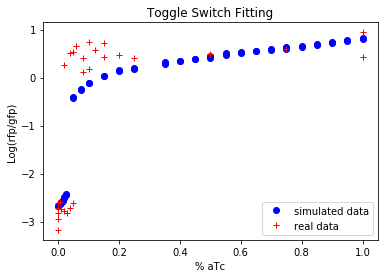

In [20]:
#Inital Parameters
alpha_1 = 13.609  # Hard Coded
alpha_2 = 60.882  # Hard Coded
beta_1 = 3529.923  # Hard Coded 
beta_2 = 1053.916  # Hard Coded
K_1 = 7.5   
K_2 = 0.5   
kappa_1 = 11.65  
kappa_2 = 0.0906 

num = 100
u_vals = [0,0.005, 0.01, 0.015, 0.02, 0.025, 0.05, 0.075, 0.10, 0.15, 0.20,0.25,0.35,0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70,0.75,0.80, 0.85, 0.9, 0.95, 1]
u_list = [(u,True,num) for u in u_vals]+[(u,False,num) for u in u_vals]

iptg_min=0
iptg_max=0.50
atc_min=0
atc_max=50
endpoints =np.array([[atc_max,iptg_min],[atc_min,iptg_max]])


# Variables to initalize the while loop 
param = np.log([K_1, kappa_1, K_2, kappa_2])
h = 0
# opt.minimize is designed to fail in this case, is only being used to set up the while loop to run
    # multiple iterations in the case that the tolerance bound is not meet
est2 = opt.minimize(s_error, param)

while est2['success'] == False:
    # The while loop is set up so that if the Nelder-Mead gets caught in an artifital bound, variance is added
        # to find the correct bound
    # Uses a summarized version of the data to reduce the variability within the data
    

    dataset_batch = generate_data(u_list, endpoints, param, batch =True)

    real_batch_data = pd.read_csv('Genetic_toggle_switch_test_data.csv',index_col=0)
    real_batch_data['perc']=real_batch_data['perc']/100
   
    sse = squared_error(param, real_batch_data)

    s_error = lambda p: squared_error(p,real_batch_data)

    est2=opt.minimize(s_error, param, method='Nelder-Mead', tol=1e-6)
    
    param = est2['x']
    param = param + np.random.multivariate_normal(param,np.diagflat((param)**2))
     
    h += 1 
        
    print(h)
    
param = est2['x']

#Plotting of experimental and simulated rfp/gfp ratio 
dataset_batch = generate_data(u_list, endpoints, est2['x'], batch =True)
plt.plot(dataset_batch['perc'], np.log(dataset_batch['rfp']/dataset_batch['gfp']),'bo', label = "simulated data")
plt.plot(real_batch_data['perc'], np.log(real_batch_data['rfp']/real_batch_data['gfp']),'r+', label = "real data")
plt.title("Toggle Switch Fitting")
plt.ylabel("Log(rfp/gfp)")
plt.xlabel("% aTc")
plt.legend()
plt.show()
